# Method 5 - Best Minus Rest Top 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 5].copy()                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

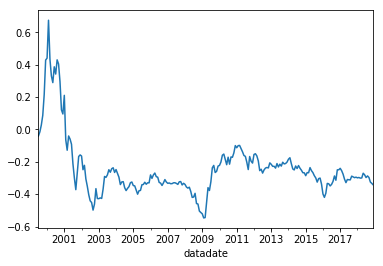

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.427671
2000-12-31   -0.233019
2001-12-31   -0.230872
2002-12-31   -0.319828
2003-12-31    0.281243
2004-12-31   -0.080343
2005-12-31   -0.007845
2006-12-31    0.007949
2007-12-31   -0.011975
2008-12-31   -0.270415
2009-12-31    0.588970
2010-12-31    0.163822
2011-12-31   -0.119985
2012-12-31    0.001659
2013-12-31    0.006026
2014-12-31   -0.082840
2015-12-31   -0.095864
2016-12-31    0.133914
2017-12-31   -0.060605
2018-12-31   -0.068055
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     135.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.20e-59
Time:                        04:43:20   Log-Likelihood:                 486.47
No. Observations:                 234   AIC:                            -962.9
Df Residuals:                     229   BIC:                            -945.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.606      0.545      -0.003       0.005
mktrf          0.3957      0.057      6.935      0.000       0.283       0.508
me             0.2387      0.066      3.597      0.000       0.108       0.370
ia            -0.3755      0.101     -3.723      0.000      -0.574      -0.177
roe           -0.9059      0.086    -10.492      0.000      -1.076      -0.736
==============================================================================
Omnibus:                       38.965   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.655
Skew:                           0.704   Prob(JB):                     1.54e-24
Kurtosis:                       6.044   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     72.56
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.27e-39
Time:                        04:43:20   Log-Likelihood:                 486.47
No. Observations:                 234   AIC:                            -962.9
Df Residuals:                     229   BIC:                            -945.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.549      0.583      -0.003       0.006
mktrf          0.3957      0.094      4.215      0.000       0.212       0.580
me             0.2387      0.094      2.538      0.011       0.054       0.423
ia            -0.3755      0.161     -2.336      0.019      -0.691      -0.060
roe           -0.9059      0.137     -6.596      0.000      -1.175      -0.637
==============================================================================
Omnibus:                       38.965   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.655
Skew:                           0.704   Prob(JB):                     1.54e-24
Kurtosis:                       6.044   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     136.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.02e-59
Time:                        04:43:20   Log-Likelihood:                 486.47
No. Observations:                 234   AIC:                            -962.9
Df Residuals:                     229   BIC:                            -945.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.518      0.604      -0.004       0.006
mktrf          0.3957      0.096      4.134      0.000       0.208       0.583
me             0.2387      0.105      2.273      0.023       0.033       0.445
ia            -0.3755      0.157     -2.390      0.017      -0.684      -0.068
roe           -0.9059      0.148     -6.128      0.000      -1.196      -0.616
==============================================================================
Omnibus:                       38.965   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.655
Skew:                           0.704   Prob(JB):                     1.54e-24
Kurtosis:                       6.044   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     107.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.98e-58
Time:                        04:43:20   Log-Likelihood:                 485.75
No. Observations:                 234   AIC:                            -959.5
Df Residuals:                     228   BIC:                            -938.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.777      0.438      -0.003       0.006
mktrf          0.4400      0.057      7.656      0.000       0.327       0.553
smb            0.1912      0.076      2.521      0.012       0.042       0.341
hml            0.0650      0.089      0.726      0.468      -0.111       0.241
rmw           -0.9876      0.101     -9.769      0.000      -1.187      -0.788
cma           -0.2210      0.128     -1.720      0.087      -0.474       0.032
==============================================================================
Omnibus:                       81.233   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              272.002
Skew:                           1.446   Prob(JB):                     8.62e-60
Kurtosis:                       7.420   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     42.92
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.62e-31
Time:                        04:43:20   Log-Likelihood:                 485.75
No. Observations:                 234   AIC:                            -959.5
Df Residuals:                     228   BIC:                            -938.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.721      0.471      -0.003       0.006
mktrf          0.4400      0.062      7.089      0.000       0.318       0.562
smb            0.1912      0.077      2.485      0.013       0.040       0.342
hml            0.0650      0.130      0.498      0.618      -0.190       0.320
rmw           -0.9876      0.122     -8.081      0.000      -1.227      -0.748
cma           -0.2210      0.182     -1.215      0.224      -0.577       0.135
==============================================================================
Omnibus:                       81.233   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              272.002
Skew:                           1.446   Prob(JB):                     8.62e-60
Kurtosis:                       7.420   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     52.27
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.69e-36
Time:                        04:43:20   Log-Likelihood:                 485.75
No. Observations:                 234   AIC:                            -959.5
Df Residuals:                     228   BIC:                            -938.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.634      0.526      -0.003       0.007
mktrf          0.4400      0.061      7.163      0.000       0.320       0.560
smb            0.1912      0.084      2.270      0.023       0.026       0.356
hml            0.0650      0.099      0.655      0.512      -0.129       0.259
rmw           -0.9876      0.120     -8.221      0.000      -1.223      -0.752
cma           -0.2210      0.156     -1.417      0.157      -0.527       0.085
==============================================================================
Omnibus:                       81.233   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              272.002
Skew:                           1.446   Prob(JB):                     8.62e-60
Kurtosis:                       7.420   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     109.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.27e-52
Time:                        04:43:20   Log-Likelihood:                 469.64
No. Observations:                 234   AIC:                            -929.3
Df Residuals:                     229   BIC:                            -912.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -0.995      0.321      -0.006       0.002
mktrf          0.5606      0.056      9.932      0.000       0.449       0.672
smb            0.6385      0.070      9.061      0.000       0.500       0.777
hml           -0.3341      0.070     -4.774      0.000      -0.472      -0.196
umd           -0.3262      0.046     -7.103      0.000      -0.417      -0.236
==============================================================================
Omnibus:                       35.615   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.416
Skew:                           0.786   Prob(JB):                     2.29e-15
Kurtosis:                       5.109   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     55.60
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.03e-32
Time:                        04:43:20   Log-Likelihood:                 469.64
No. Observations:                 234   AIC:                            -929.3
Df Residuals:                     229   BIC:                            -912.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -1.073      0.283      -0.006       0.002
mktrf          0.5606      0.076      7.362      0.000       0.411       0.710
smb            0.6385      0.087      7.352      0.000       0.468       0.809
hml           -0.3341      0.114     -2.922      0.003      -0.558      -0.110
umd           -0.3262      0.076     -4.298      0.000      -0.475      -0.177
==============================================================================
Omnibus:                       35.615   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.416
Skew:                           0.786   Prob(JB):                     2.29e-15
Kurtosis:                       5.109   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     81.96
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.45e-43
Time:                        04:43:20   Log-Likelihood:                 469.64
No. Observations:                 234   AIC:                            -929.3
Df Residuals:                     229   BIC:                            -912.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -1.083      0.279      -0.006       0.002
mktrf          0.5606      0.080      6.975      0.000       0.403       0.718
smb            0.6385      0.079      8.081      0.000       0.484       0.793
hml           -0.3341      0.123     -2.726      0.006      -0.574      -0.094
umd           -0.3262      0.079     -4.142      0.000      -0.481      -0.172
==============================================================================
Omnibus:                       35.615   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.416
Skew:                           0.786   Prob(JB):                     2.29e-15
Kurtosis:                       5.109   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     73.18
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.05e-30
Time:                        04:43:20   Log-Likelihood:                 226.90
No. Observations:                 120   AIC:                            -443.8
Df Residuals:                     115   BIC:                            -429.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      1.235      0.219      -0.003       0.011
mktrf          0.3836      0.096      3.989      0.000       0.193       0.574
me             0.1732      0.095      1.823      0.071      -0.015       0.361
ia            -0.5448      0.149     -3.663      0.000      -0.839      -0.250
roe           -0.8902      0.132     -6.762      0.000      -1.151      -0.629
==============================================================================
Omnibus:                        8.299   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               10.198
Skew:                           0.401   Prob(JB):                      0.00610
Kurtosis:                       4.182   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     43.26
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.20e-22
Time:                        04:43:20   Log-Likelihood:                 226.90
No. Observations:                 120   AIC:                            -443.8
Df Residuals:                     115   BIC:                            -429.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      1.175      0.240      -0.003       0.012
mktrf          0.3836      0.146      2.630      0.009       0.098       0.670
me             0.1732      0.120      1.440      0.150      -0.063       0.409
ia            -0.5448      0.206     -2.651      0.008      -0.948      -0.142
roe           -0.8902      0.200     -4.444      0.000      -1.283      -0.498
==============================================================================
Omnibus:                        8.299   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               10.198
Skew:                           0.401   Prob(JB):                      0.00610
Kurtosis:                       4.182   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     85.60
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.47e-33
Time:                        04:43:20   Log-Likelihood:                 226.90
No. Observations:                 120   AIC:                            -443.8
Df Residuals:                     115   BIC:                            -429.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      1.155      0.248      -0.003       0.012
mktrf          0.3836      0.147      2.617      0.009       0.096       0.671
me             0.1732      0.135      1.286      0.198      -0.091       0.437
ia            -0.5448      0.186     -2.925      0.003      -0.910      -0.180
roe           -0.8902      0.218     -4.078      0.000      -1.318      -0.462
==============================================================================
Omnibus:                        8.299   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               10.198
Skew:                           0.401   Prob(JB):                      0.00610
Kurtosis:                       4.182   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     61.88
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.98e-31
Time:                        04:43:20   Log-Likelihood:                 229.68
No. Observations:                 120   AIC:                            -447.4
Df Residuals:                     114   BIC:                            -430.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.004      1.685      0.095      -0.001       0.013
mktrf          0.5004      0.100      5.028      0.000       0.303       0.698
smb            0.1203      0.113      1.067      0.288      -0.103       0.344
hml           -0.1442      0.138     -1.044      0.299      -0.418       0.129
rmw           -0.8622      0.163     -5.294      0.000      -1.185      -0.540
cma           -0.2009      0.178     -1.126      0.263      -0.554       0.153
==============================================================================
Omnibus:                       43.230   Durbin-Watson:                   1.784
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.825
Skew:                           1.447   Prob(JB):                     3.47e-22
Kurtosis:                       6.375   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     32.92
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.17e-20
Time:                        04:43:20   Log-Likelihood:                 229.68
No. Observations:                 120   AIC:                            -447.4
Df Residuals:                     114   BIC:                            -430.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      1.909      0.056      -0.000       0.012
mktrf          0.5004      0.113      4.440      0.000       0.280       0.721
smb            0.1203      0.102      1.178      0.239      -0.080       0.320
hml           -0.1442      0.098     -1.473      0.141      -0.336       0.048
rmw           -0.8622      0.167     -5.173      0.000      -1.189      -0.535
cma           -0.2009      0.203     -0.987      0.324      -0.600       0.198
==============================================================================
Omnibus:                       43.230   Durbin-Watson:                   1.784
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.825
Skew:                           1.447   Prob(JB):                     3.47e-22
Kurtosis:                       6.375   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     38.38
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.21e-23
Time:                        04:43:20   Log-Likelihood:                 229.68
No. Observations:                 120   AIC:                            -447.4
Df Residuals:                     114   BIC:                            -430.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.004      1.703      0.089      -0.001       0.013
mktrf          0.5004      0.097      5.141      0.000       0.310       0.691
smb            0.1203      0.106      1.139      0.255      -0.087       0.327
hml           -0.1442      0.062     -2.338      0.019      -0.265      -0.023
rmw           -0.8622      0.166     -5.187      0.000      -1.188      -0.536
cma           -0.2009      0.167     -1.203      0.229      -0.528       0.126
==============================================================================
Omnibus:                       43.230   Durbin-Watson:                   1.784
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.825
Skew:                           1.447   Prob(JB):                     3.47e-22
Kurtosis:                       6.375   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     74.95
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.92e-31
Time:                        04:43:20   Log-Likelihood:                 227.93
No. Observations:                 120   AIC:                            -445.9
Df Residuals:                     115   BIC:                            -431.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.420      0.676      -0.005       0.008
mktrf          0.6365      0.084      7.577      0.000       0.470       0.803
smb            0.5462      0.096      5.711      0.000       0.357       0.736
hml           -0.5467      0.096     -5.708      0.000      -0.736      -0.357
umd           -0.2879      0.059     -4.875      0.000      -0.405      -0.171
==============================================================================
Omnibus:                        9.640   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.568
Skew:                           0.531   Prob(JB):                      0.00507
Kurtosis:                       3.992   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     42.31
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.91e-22
Time:                        04:43:20   Log-Likelihood:                 227.93
No. Observations:                 120   AIC:                            -445.9
Df Residuals:                     115   BIC:                            -431.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.472      0.637      -0.005       0.007
mktrf          0.6365      0.105      6.058      0.000       0.431       0.842
smb            0.5462      0.094      5.816      0.000       0.362       0.730
hml           -0.5467      0.105     -5.189      0.000      -0.753      -0.340
umd           -0.2879      0.078     -3.690      0.000      -0.441      -0.135
==============================================================================
Omnibus:                        9.640   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.568
Skew:                           0.531   Prob(JB):                      0.00507
Kurtosis:                       3.992   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     69.02
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.13e-29
Time:                        04:43:20   Log-Likelihood:                 227.93
No. Observations:                 120   AIC:                            -445.9
Df Residuals:                     115   BIC:                            -431.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.482      0.630      -0.004       0.007
mktrf          0.6365      0.105      6.047      0.000       0.430       0.843
smb            0.5462      0.083      6.563      0.000       0.383       0.709
hml           -0.5467      0.085     -6.414      0.000      -0.714      -0.380
umd           -0.2879      0.080     -3.602      0.000      -0.445      -0.131
==============================================================================
Omnibus:                        9.640   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.568
Skew:                           0.531   Prob(JB):                      0.00507
Kurtosis:                       3.992   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     65.55
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.91e-28
Time:                        04:43:20   Log-Likelihood:                 284.68
No. Observations:                 114   AIC:                            -559.4
Df Residuals:                     109   BIC:                            -545.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.587      0.558      -0.005       0.003
mktrf          0.3719      0.060      6.211      0.000       0.253       0.491
me             0.3967      0.092      4.290      0.000       0.213       0.580
ia             0.0026      0.128      0.020      0.984      -0.252       0.257
roe           -0.8709      0.113     -7.728      0.000      -1.094      -0.648
==============================================================================
Omnibus:                       30.439   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.030
Skew:                           1.037   Prob(JB):                     1.69e-15
Kurtosis:                       6.166   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     55.35
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.12e-25
Time:                        04:43:20   Log-Likelihood:                 284.68
No. Observations:                 114   AIC:                            -559.4
Df Residuals:                     109   BIC:                            -545.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.657      0.511      -0.005       0.002
mktrf          0.3719      0.081      4.616      0.000       0.214       0.530
me             0.3967      0.124      3.209      0.001       0.154       0.639
ia             0.0026      0.167      0.015      0.988      -0.324       0.329
roe           -0.8709      0.147     -5.921      0.000      -1.159      -0.583
==============================================================================
Omnibus:                       30.439   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.030
Skew:                           1.037   Prob(JB):                     1.69e-15
Kurtosis:                       6.166   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     68.88
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.81e-29
Time:                        04:43:20   Log-Likelihood:                 284.68
No. Observations:                 114   AIC:                            -559.4
Df Residuals:                     109   BIC:                            -545.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.619      0.536      -0.005       0.003
mktrf          0.3719      0.083      4.502      0.000       0.210       0.534
me             0.3967      0.140      2.824      0.005       0.121       0.672
ia             0.0026      0.188      0.014      0.989      -0.366       0.371
roe           -0.8709      0.150     -5.802      0.000      -1.165      -0.577
==============================================================================
Omnibus:                       30.439   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.030
Skew:                           1.037   Prob(JB):                     1.69e-15
Kurtosis:                       6.166   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     52.68
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.01e-27
Time:                        04:43:20   Log-Likelihood:                 285.24
No. Observations:                 114   AIC:                            -558.5
Df Residuals:                     108   BIC:                            -542.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.909      0.365      -0.006       0.002
mktrf          0.3916      0.057      6.859      0.000       0.278       0.505
smb            0.3421      0.093      3.691      0.000       0.158       0.526
hml            0.4089      0.118      3.459      0.001       0.175       0.643
rmw           -0.8747      0.145     -6.043      0.000      -1.162      -0.588
cma           -0.2218      0.184     -1.207      0.230      -0.586       0.142
==============================================================================
Omnibus:                        8.137   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.080
Skew:                           0.527   Prob(JB):                       0.0176
Kurtosis:                       3.767   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     32.91
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.89e-20
Time:                        04:43:20   Log-Likelihood:                 285.24
No. Observations:                 114   AIC:                            -558.5
Df Residuals:                     108   BIC:                            -542.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.817      0.414      -0.006       0.003
mktrf          0.3916      0.058      6.744      0.000       0.278       0.505
smb            0.3421      0.108      3.176      0.001       0.131       0.553
hml            0.4089      0.155      2.637      0.008       0.105       0.713
rmw           -0.8747      0.166     -5.270      0.000      -1.200      -0.549
cma           -0.2218      0.222     -1.001      0.317      -0.656       0.213
==============================================================================
Omnibus:                        8.137   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.080
Skew:                           0.527   Prob(JB):                       0.0176
Kurtosis:                       3.767   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     43.73
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.89e-24
Time:                        04:43:21   Log-Likelihood:                 285.24
No. Observations:                 114   AIC:                            -558.5
Df Residuals:                     108   BIC:                            -542.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.786      0.432      -0.006       0.003
mktrf          0.3916      0.059      6.636      0.000       0.276       0.507
smb            0.3421      0.113      3.015      0.003       0.120       0.565
hml            0.4089      0.127      3.225      0.001       0.160       0.657
rmw           -0.8747      0.144     -6.095      0.000      -1.156      -0.593
cma           -0.2218      0.226     -0.980      0.327      -0.665       0.222
==============================================================================
Omnibus:                        8.137   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.080
Skew:                           0.527   Prob(JB):                       0.0176
Kurtosis:                       3.767   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     48.26
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.69e-23
Time:                        04:43:21   Log-Likelihood:                 272.93
No. Observations:                 114   AIC:                            -535.9
Df Residuals:                     109   BIC:                            -522.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.002     -1.292      0.199      -0.007       0.002
mktrf          0.4263      0.063      6.776      0.000       0.302       0.551
smb            0.5533      0.098      5.640      0.000       0.359       0.748
hml            0.3149      0.101      3.117      0.002       0.115       0.515
umd           -0.2649      0.076     -3.476      0.001      -0.416      -0.114
==============================================================================
Omnibus:                       10.491   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.195
Skew:                           0.477   Prob(JB):                     0.000827
Kurtosis:                       4.442   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     38.87
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.46e-20
Time:                        04:43:21   Log-Likelihood:                 272.93
No. Observations:                 114   AIC:                            -535.9
Df Residuals:                     109   BIC:                            -522.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.002     -1.543      0.123      -0.007       0.001
mktrf          0.4263      0.065      6.585      0.000       0.299       0.553
smb            0.5533      0.109      5.095      0.000       0.340       0.766
hml            0.3149      0.135      2.340      0.019       0.051       0.579
umd           -0.2649      0.090     -2.948      0.003      -0.441      -0.089
==============================================================================
Omnibus:                       10.491   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.195
Skew:                           0.477   Prob(JB):                     0.000827
Kurtosis:                       4.442   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     44.59
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.95e-22
Time:                        04:43:21   Log-Likelihood:                 272.93
No. Observations:                 114   AIC:                            -535.9
Df Residuals:                     109   BIC:                            -522.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.002     -1.593      0.111      -0.006       0.001
mktrf          0.4263      0.065      6.585      0.000       0.299       0.553
smb            0.5533      0.098      5.635      0.000       0.361       0.746
hml            0.3149      0.132      2.391      0.017       0.057       0.573
umd           -0.2649      0.093     -2.854      0.004      -0.447      -0.083
==============================================================================
Omnibus:                       10.491   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.195
Skew:                           0.477   Prob(JB):                     0.000827
Kurtosis:                       4.442   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""